In [19]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
X_train = pd.read_csv('../data/raw/X_train.csv')
y_train = pd.read_csv('../data/raw/y_train.csv')
X_test = pd.read_csv('../data/raw/X_test.csv')

In [3]:
index2label = dict(enumerate(y_train.surface.unique()))
label2index = dict(map(reversed,enumerate(y_train.surface.unique())))
y_train['surface'] = y_train.surface.map(lambda x:label2index[x])

In [20]:
train_df = X_train.drop(columns=['row_id'])
test_df = X_test.drop(columns=['row_id'])

In [21]:
# train
train_df['norm_quanterion'] = train_df['orientation_X']**2+train_df['orientation_Y']**2+train_df['orientation_Z']**2+train_df['orientation_W']**2
train_df['mod_quanterion'] = train_df['norm_quanterion']**0.5
train_df['norm_X'] = train_df['orientation_X']/train_df['mod_quanterion']
train_df['norm_Y'] = train_df['orientation_Y']/train_df['mod_quanterion']
train_df['norm_Z'] = train_df['orientation_Z']/train_df['mod_quanterion']
train_df['norm_W'] = train_df['orientation_W']/train_df['mod_quanterion']
# test
test_df['norm_quanterion'] = test_df['orientation_X']**2+test_df['orientation_Y']**2+test_df['orientation_Z']**2+test_df['orientation_W']**2
test_df['mod_quanterion'] = test_df['norm_quanterion']**0.5
test_df['norm_X'] = test_df['orientation_X']/test_df['mod_quanterion']
test_df['norm_Y'] = test_df['orientation_Y']/test_df['mod_quanterion']
test_df['norm_Z'] = test_df['orientation_Z']/test_df['mod_quanterion']
test_df['norm_W'] = test_df['orientation_W']/test_df['mod_quanterion']

In [22]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = np.arctan2(t0, t1)

    t2 = 2.0 * (w * y - z * x)
    t2[t2 >1.0] = 1.0
    t2[t2 < -1.0] = -1.0
    Y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = np.arctan2(t3, t4)

    return X, Y, Z

In [23]:
# train
x,y,z,w = train_df['norm_X'],train_df['norm_Y'],train_df['norm_Z'],train_df['norm_W']
X,Y,Z = quaternion_to_euler(x,y,z,w)
train_df['euler_X'],train_df['euler_Y'],train_df['euler_Z'] = X,Y,Z
# test
x,y,z,w = test_df['norm_X'],test_df['norm_Y'],test_df['norm_Z'],test_df['norm_W']
X,Y,Z = quaternion_to_euler(x,y,z,w)
test_df['euler_X'],test_df['euler_Y'],test_df['euler_Z'] = X,Y,Z

In [24]:
# train
train_df['orientation'] = (train_df['euler_X']**2+train_df['euler_Y']**2+train_df['euler_Z']**2)**0.5
train_df['acceleration'] = (train_df['linear_acceleration_X']**2+train_df['linear_acceleration_Y']**2+train_df['linear_acceleration_Z']**2)**0.5
train_df['velocity'] = (train_df['angular_velocity_X']**2+train_df['angular_velocity_Y']**2+train_df['angular_velocity_Z']**2)**0.5
# test
test_df['orientation'] = (test_df['euler_X']**2+test_df['euler_Y']**2+test_df['euler_Z']**2)**0.5
test_df['acceleration'] = (test_df['linear_acceleration_X']**2+test_df['linear_acceleration_Y']**2+test_df['linear_acceleration_Z']**2)**0.5
test_df['velocity'] = (test_df['angular_velocity_X']**2+test_df['angular_velocity_Y']**2+test_df['angular_velocity_Z']**2)**0.5

In [25]:
# columns = ['series_id','measurement_number','orientation','acceleration','velocity','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z','angular_velocity_X','angular_velocity_Y','angular_velocity_Z']
# train_df = train_df[columns]
# test_df = test_df[columns]

In [26]:
# start end point train
start = train_df.query("measurement_number==0").reset_index()
end = train_df.query("measurement_number==127").reset_index()
columns = [x for x in train_df.columns if x not in ['measurement_number']]
start, end = start[columns], end[columns]
train_sec = start.merge(end,on='series_id',how='left',suffixes=('_start', '_end'))
for col in train_df.columns:
    if col not in ['series_id','measurement_number']:
        train_sec['%s_change'%col] = train_sec['%s_end'%col]-train_sec['%s_start'%col]
# start end point test
start = test_df.query("measurement_number==0").reset_index()
end = test_df.query("measurement_number==127").reset_index()
columns = [x for x in test_df.columns if x not in ['measurement_number']]
start, end = start[columns], end[columns]
test_sec = start.merge(end,on='series_id',how='left',suffixes=('_start', '_end'))
for col in test_df.columns:
    if col not in ['series_id','measurement_number']:
        test_sec['%s_change'%col] = test_sec['%s_end'%col]-test_sec['%s_start'%col]

In [27]:
train_df.drop(columns=['measurement_number'],inplace=True)
test_df.drop(columns=['measurement_number'],inplace=True)

In [28]:
# train
train_df = train_df.groupby('series_id').agg(['mean','median','max','min','std'])
columns = ['%s_%s'%(col1,col2) for col1 in train_df.columns.levels[0] for col2 in train_df.columns.levels[1]]
train_df.columns= columns
train_df = train_df.reset_index()
# test
test_df = test_df.groupby('series_id').agg(['mean','median','max','min','std'])
columns = ['%s_%s'%(col1,col2) for col1 in test_df.columns.levels[0] for col2 in test_df.columns.levels[1]]
test_df.columns= columns
test_df = test_df.reset_index()

In [29]:
train_df = train_df.merge(train_sec,on='series_id',how='left')
test_df = test_df.merge(test_sec,on='series_id',how='left')

In [30]:
# train
train_df = train_df.merge(y_train[['series_id','surface']],how='left',on=['series_id'])
train_df.drop(columns=['series_id'],inplace=True)
# test
series_id = test_df.pop('series_id')

In [220]:
# train_df = train_df[train_df.corr()[train_df.corr().surface.abs().sort_values()>=0.1].index]

In [31]:
# train
train_df['ax_min'] = train_df.drop(columns=['surface']).min(axis=1)
train_df['ax_max'] = train_df.drop(columns=['surface']).max(axis=1)
train_df['ax_median'] = train_df.drop(columns=['surface']).median(axis=1)
train_df['ax_mean'] = train_df.drop(columns=['surface']).mean(axis=1)
train_df['ax_std'] = train_df.drop(columns=['surface']).std(axis=1)
train_df['ax_var'] = train_df.drop(columns=['surface']).var(axis=1)
# test
test_df['ax_min'] = test_df.min(axis=1)
test_df['ax_max'] = test_df.max(axis=1)
test_df['ax_median'] = test_df.median(axis=1)
test_df['ax_mean'] = test_df.mean(axis=1)
test_df['ax_std'] = test_df.std(axis=1)
test_df['ax_var'] = test_df.var(axis=1)

In [32]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(train_df.drop(columns=['surface']))
temp = pd.DataFrame(scaled,columns=[x for x in train_df.columns if x not in ['surface']])
temp['surface'] = train_df['surface']
train_df = temp
test_df = pd.DataFrame(scaler.transform(test_df),columns=test_df.columns)

In [33]:
def plot_feature_distribution(df,target,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    row = len(features)//4+len(features)%2
    fig, ax = plt.subplots(row,4,figsize=(10*4,10*row))

    for feature in features:
        i += 1
        plt.subplot(row,4,i)
        for l in df[target].unique():
            sns.kdeplot(df[df[target]==l][feature], bw=0.5,label=l)
        plt.xlabel(feature, fontsize=30)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=20, pad=2)
        plt.tick_params(axis='y', which='major', labelsize=20)
    plt.show();

<Figure size 432x288 with 0 Axes>

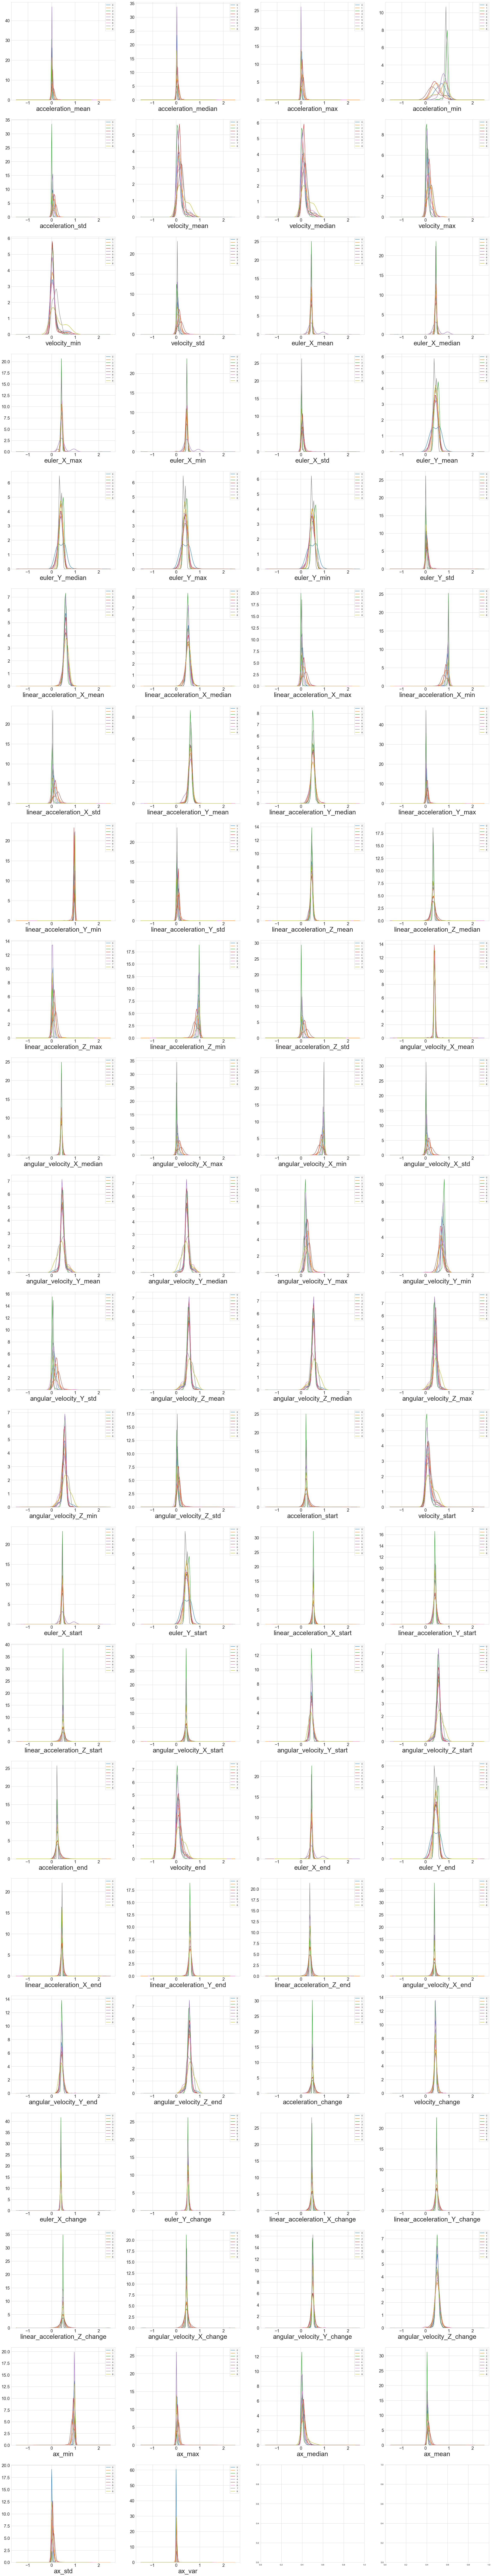

In [185]:
features = [x for x in train_df.columns if x not in ['series_id','surface']]
plot_feature_distribution(train_df, 'surface', features)

In [34]:
def plot_train_test_distribution(df1,df2,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    row = len(features)//4+len(features)%2
    fig, ax = plt.subplots(row,4,figsize=(10*4,10*row))
    for feature in features:
        i += 1
        plt.subplot(row,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label='train')
        sns.kdeplot(df2[feature], bw=0.5,label='test')
        plt.xlabel(feature, fontsize=30)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=20, pad=2)
        plt.tick_params(axis='y', which='major', labelsize=20)
    plt.show();

<Figure size 432x288 with 0 Axes>

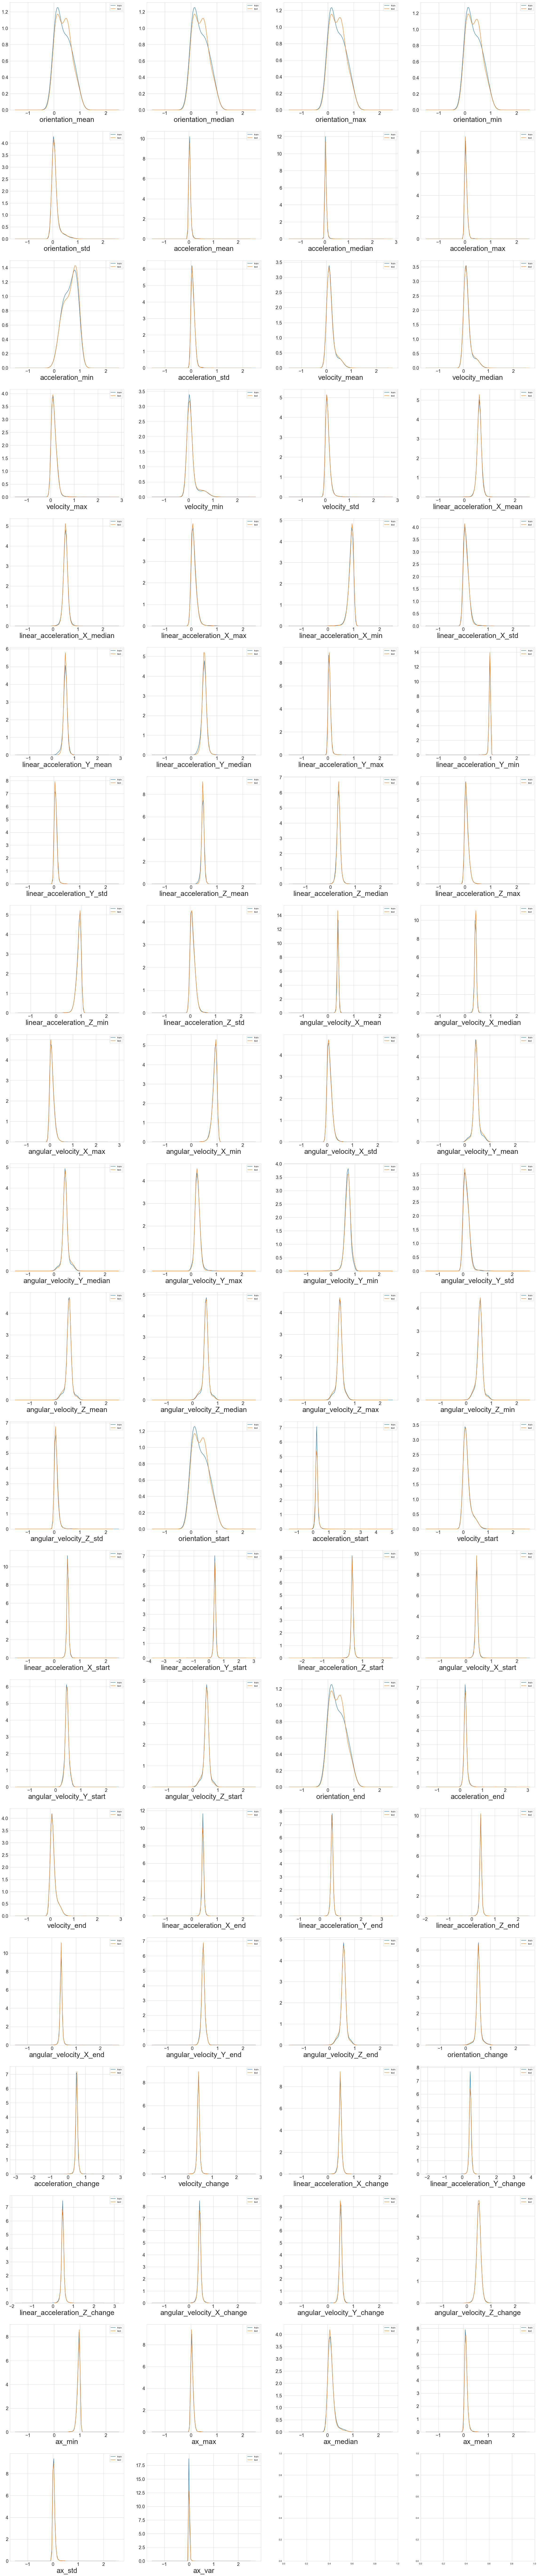

In [224]:
features = [x for x in train_df.columns if x not in ['series_id','surface']]
plot_train_test_distribution(train_df,test_df, features)

In [35]:
train_x, test_x, train_y, test_y = train_test_split(train_df.drop(columns=['surface']), train_df.surface, test_size=0.20,random_state = 42,stratify = train_df.surface)

In [ ]:
cab_bin = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="Accuracy",
    task_type="GPU",
    learning_rate=0.09,
    iterations=10000,
    random_seed=42,
    od_type="Iter",
    depth=7,
    l2_leaf_reg = 100,
    early_stopping_rounds=500
)

In [ ]:
trn_data_bin = Pool(train_x, label=train_y)
val_data_bin = Pool(test_x, label=test_y)
cab_bin.fit(
    trn_data_bin,
    eval_set = val_data_bin,
    use_best_model=True,
    verbose=200,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6276247	test: 0.6272966	best: 0.6272966 (0)	total: 153ms	remaining: 25m 25s
200:	learn: 0.9993438	test: 0.8215223	best: 0.8254593 (173)	total: 26.6s	remaining: 21m 38s
400:	learn: 0.9993438	test: 0.8267717	best: 0.8307087 (352)	total: 52s	remaining: 20m 45s


In [23]:
pred_cat = cab_bin.predict_proba(test_df.values).argmax(axis=1)

In [24]:
submission = pd.DataFrame({'series_id':series_id,'surface':pred_cat})
submission['surface'] = submission['surface'].map(lambda x:index2label[x])

In [25]:
submission.to_csv('submission_cat.csv',index=False)

## Applying Deeplearning

In [16]:
import sys
import torch
import torch.nn as nn
from IPython import display
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
def update_progress(progress,line):
    '''
    update_progress() : Displays or updates a console progress bar
    Accepts a float between 0 and 1. Any int will be converted to a float.
    A value under 0 represents a 'halt'.
    A value at 1 or bigger represents 100%
    '''
    barLength = 50 # Modify this to change the length of the progress bar
    status = line
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float"
    if progress < 0:
        progress = 0
        status = "Halt..."
    if progress >= 1:
        progress = 1
        status = "Done..."+" "*50
    block = int(round(barLength*progress))
    text = "\rPercent: [{:s}] {:.2f}% {:s}".format( "█"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [41]:
class TrainDataset(Dataset):
    def __init__(self,dataFrame):
        self.input = dataFrame
        self.target = self.input.pop('surface')

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        data = self.input.iloc[idx].values
        target = self.target.iloc[idx]
        return data,target

In [42]:
train_dataset = TrainDataset(train_df.copy())

In [43]:
train_dataset[0][0].shape

(66,)

In [44]:
batch_size = 500
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
splitter = sss.split(train_dataset.input, train_dataset.target)
train_indices, val_indices = next(splitter)
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=val_sampler)

In [45]:
class Model(nn.Module):        
    def __init__(self):
        super(Model,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(66,256),
            nn.BatchNorm1d(256),
            nn.ReLU())
        
        self.layer2 = nn.GRU(66,256,2, bidirectional=True,dropout=0.0)
        
        self.layer3 = nn.Sequential(
            nn.Linear(66,256),
            nn.BatchNorm1d(256),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1,padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        
        self.layer8 = nn.GRU(256,256,2, bidirectional=True,dropout=0.0)
        
        self.layer9 = nn.Sequential(
            nn.Linear(256,9),
            nn.BatchNorm1d(9),
            nn.Softmax(dim=1))
        
    def forward(self,x):
        output1 = self.layer1(x)
        output1 = output1.view(-1,1,256)
        hidden = torch.zeros(4,x.size(0),256)
        if torch.cuda.is_available():
            hidden = hidden.cuda()
        output2, hidden = self.layer2(x.unsqueeze(0),hidden)
        output2 = output2[:,:,256:]+output2[:,:,:256]
        output2 = output2.view(-1,1,256)
        output3 = torch.sigmoid(self.layer3(torch.sin(x)))
        output3 = output3.view(-1,1,256)
        output = torch.cat((output1,output2,output3),dim=1)
        output = output.view(-1,3,16,16)
        output = self.layer4(output)
        output = self.layer5(output)
        output = self.layer6(output)
        output = self.layer7(output)
        output = output.view(-1,256)
        output = output.unsqueeze(0)
        output,hidden = self.layer8(output,hidden)
        output = output[:,:,256:]+output[:,:,:256]
        output = output.squeeze(0)
        output = self.layer9(output)
        return output

In [46]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
exp_lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.1, patience=10,verbose=True)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [47]:
def accuracy_metric(y_true,y_pred):
    accuracy = torch.FloatTensor()
    if torch.cuda.is_available():
        accuracy = accuracy.cuda()
    for value in y_true.unique():
        i_true = torch.nonzero(y_true==value)
        pred = (y_pred[i_true]==value).float().mean().view(-1,1)
        accuracy = torch.cat((accuracy,pred),dim=0)
    return accuracy.mean()

In [48]:
def validate():
    total_loss = 0
    total_accuracy = 0
    completed = 0
    model.eval()
    for batch_idx, (data,target) in enumerate(val_loader,start = 1):
        data = data.float()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data)
        # backward + optimize
        loss = criterion(output, target).item()
        # print statistics
        topv,topi = output.topk(1)
        accuracy = accuracy_metric(target, topi.view_as(target).detach()).item()
        total_accuracy += accuracy
        total_loss+=loss
        # print statistics
        completed += target.size(0)/len(val_indices)
        update_progress(completed,"Accuracy: {:.2f} Loss: {:.4f}".format(accuracy*100,loss))
    print("\nValidation Accuracy:",round(total_accuracy*100/batch_idx,2),'Validation Loss:',round(total_loss/batch_idx,4))
    return total_accuracy/batch_idx

In [49]:
def train(epoch):
    total_loss = 0
    total_accuracy = 0
    completed = 0
    model.train()
    print("Epoch:",epoch)
    for batch_idx, (data,target) in enumerate(train_loader,start = 1):
        data = data.float()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward
        output = model(data)
        # backward + optimize
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print statistics
        topv,topi = output.topk(1)
        accuracy = accuracy_metric(target, topi.view_as(target).detach()).item()
        total_accuracy += accuracy
        total_loss+=loss.item()
        # print statistics
        completed += target.size(0)/len(val_indices)
        update_progress(completed,"Accuracy: {:.2f} Loss: {:.4f}".format(accuracy*100,loss.item()))
    print("\nTrain Accuracy:",round(total_accuracy*100/batch_idx,2),'Train Loss:',round(total_loss/batch_idx,4))
    val_accuracy = validate()
    exp_lr_scheduler.step(val_accuracy)
    return total_accuracy/batch_idx,val_accuracy

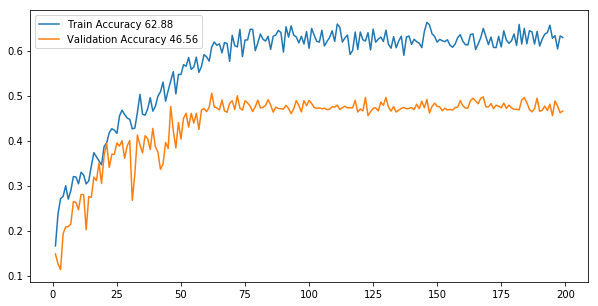

In [50]:
train_data = []
val_data = []
epoch_data = []
for i in range(1,200):
    train_score,val_score = train(i)
    train_data.append(train_score)
    val_data.append(val_score)
    epoch_data.append(i)
    # Visualize
    plt.figure(figsize=(10,5))
    plt.plot(epoch_data, train_data,label="Train Accuracy {:.2f}".format(train_data[-1]*100))
    plt.plot(epoch_data,val_data,label="Validation Accuracy {:.2f}".format(val_data[-1]*100))
    display.clear_output(wait=False)
    plt.legend()
    plt.show()

In [38]:
torch.save(model,'../models/model.pt')

In [38]:
class TestDataset(Dataset):
    def __init__(self,dataFrame):
        self.input = dataFrame

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        data = self.input.iloc[idx].values
        return data

In [39]:
test_dataset = TestDataset(test_df.copy())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [40]:
def predict():
    completed = 0
    pred = torch.IntTensor()
    model.eval()
    for batch_idx,data in enumerate(test_loader,start = 1):
        data = data.float()
        if torch.cuda.is_available():
            data = data.cuda()
            pred = pred.cuda()
        # forward
        output = model(data).detach()
        topv,topi = output.topk(1)
        # print statistics
        completed += data.size(0)/len(test_dataset)
        update_progress(completed,"")
        pred = torch.cat((pred,topi.int().view(-1)),dim=0)
    return pred

In [41]:
pred_torch = predict().cpu().numpy()

Percent: [██████████████████████████████████████████████████] 100.00% Done...                                                  

In [42]:
submission = pd.DataFrame({'series_id':series_id,'surface':pred_torch})
submission['surface'] = submission['surface'].map(lambda x:index2label[x])

In [43]:
submission.to_csv('submission_torch.csv',index=False)